# A Teaser Example
Let’s start with a very reduced example that highlights some of the key capabilities of physics-based learning approaches. Let’s assume our physical model is a very simple equation: a parabola along the positive x-axis. We’ll also directly use this example to give an outlook towards probabilistic “generative AI” approaches.
Despite being very simple, there are two solutions for every point along x, i.e. we have two modes, one above the other one below the x-axis, as shown on the left below. If we don’t take care, a conventional learning approach will give us an approximation like the red one shown in the middle, which is completely off. With an improved learning setup, e.g., by using a discretized numerical solver, we can at least accurately represent one of the modes of the solution (shown in green on the right). Interestingly, approaches that learn the full distribution at each point, flow matching as a representative of diffusion models is used below, can capture both modes!

<img src="https://www.physicsbaseddeeplearning.org/_images/intro-teaser-side-by-side.jpg" width="1015" height="200" />


## Differentiable physics
One of the key concepts of the following chapters is what we’ll call differentiable physics (DP). This means that we use domain knowledge in the form of model equations, and then integrate discretized versions of these models into the training process. As implied by the name, having differentiable formulations and operators is crucial for this process to integrate with neural networks training.
Let’s illustrate the properties of deep learning via DP with the following example: We’d like to find an unknown function $f^{*}$ that generates solutions from a space $X$, taking inputs from $Y$, i.e. $f^{*}: X \to Y $. In the following, we’ll often denote idealized, and unknown functions with a  superscript, in contrast to their discretized, realizable counterparts without this superscript. Let’s additionally assume we have a generic differential equation $P^{*}: X \to Y $ (our model equation), that encodes a property of the solutions, e.g. some real world behavior we’d like to match. Later on,$P^{*}$ will often represent time evolutions, but it could also be a conservation law (e.g., conservation of mass, then $P^{*}$ would measure divergence).

Using a neural network $f$ to learn the unknown and ideal function $f^*$, we could turn to classic _supervised_ training to obtain $f$ by collecting data. This classical setup requires a dataset by sampling $x$ from $X$ and adding the corresponding solutions $y$ from $Y$. We could obtain these, e.g., by classical numerical techniques. Then we train the NN $f$ with classic methods using this dataset.

In contrast to this supervised approach, employing a differentiable physics approach takes advantage of the fact that we can often use a discretized version of the physical model $\\mathcal P$ and employ it to guide the training of $f$. I.e., we want $f$ to be aware of our _simulator_ $\\mathcal P$, and to _interact_ with it. This can give fundamental improvements, as we'll illustrate below with a very simple example (more complex ones will follow later on).

Note that in order for the DP approach to work, $\\mathcal P$ has to be _differentiable_, as implied by the name. These differentials, in the form of a gradient, are what's driving the learning process and neural network integration.

## Finding the Inverse Function of a Parabola
To illustrate the difference of supervised and DP approaches, we consider the following simplified setting: Given the function $\\mathcal P: y\\to y^2$ for $y$ in the interval $[0,1]$, find the unknown function $f$ such that $\\mathcal P(f(x)) = x$ for all $x$ in $[0,1]$. E.g., for $x=0.5$, solutions would be $\\pm\\sqrt{0.5}$.
Note: to make things a bit more interesting, we're using $y^2$ here for $\\mathcal P$ instead of the more common $x^2$ parabola, and the _discretization_ is simply given by representing the $x$ and $y$ via floating point numbers in the computer for this simple case.

We know that possible solutions for $f$ are the positive or negative square root function (for completeness: piecewise combinations would also be possible).\n",
This sounds easy, so let's try to train a neural network to approximate this inverse mapping $f$.
Doing this in the \"classical\" supervised manner, i.e. purely based on data, is an obvious starting point. After all, this approach was shown to be a powerful tool for a variety of other applications, e.g., in computer vision.

In [2]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import matplotlib.pyplot as plt

For supervised training, we can employ our solver $\\mathcal P$ for the problem to pre-compute the solutions we need for training: We randomly choose between the positive and the negative square root. This resembles the  general case, where we would gather all data beforehand, e.g., using optimization techniques to compute the solutions or even experiments. This data collection typically does not favor one particular mode from multimodal solutions.

In [3]:
# Generating data 
# We are first picking random x from X
# Set the seed for repeatable results 
np.random.seed(0)

# Generate random x samples
N = 10000
X = np.random.random(N).astype(np.float32).reshape(-1,1) # -1 is indicating to Numpy to automatically calculate the appropiate number of rows
X

array([[0.5488135 ],
       [0.71518934],
       [0.60276335],
       ...,
       [0.7584295 ],
       [0.02378743],
       [0.8135751 ]], dtype=float32)

In [4]:
# Generation of Y-Data
np.random.seed(0)
sign = (-np.ones(N)).astype(np.float32)**np.random.randint(2, size=N)

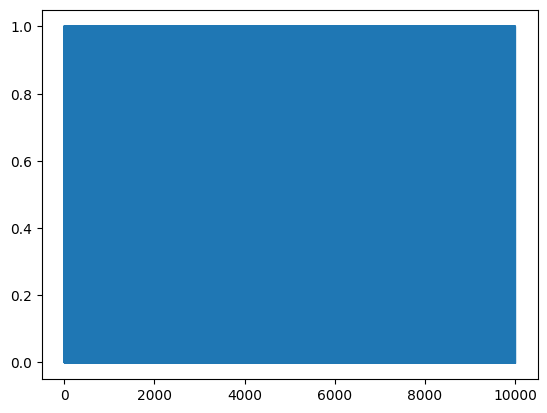

In [5]:
plt.plot(np.random.randint(2, size=N)); # This is just randomly picking between -1 and 1

In [6]:
Y = (np.sqrt(X.flatten())*sign).reshape(-1,1).astype(np.float32)

In [7]:
# We convert to PyTorch tensors
X_tensor = torch.tensor(X)
Y_tensor = torch.tensor(Y)

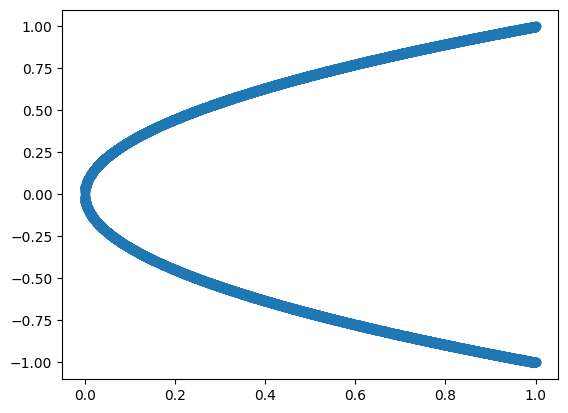

In [8]:
plt.scatter(X,Y) # We get the following data samples

Now we can define a network. We'll use a simple fully connected architecture with three hidden layers and ReLU activations.

fc1: First fully connected (linear) layer. It takes 1 input feature and outputs hiddendim features.
fc2: Second fully connected layer. It takes hiddendim inputs and outputs hiddendim features.
fc3: Final layer. It reduces the output back to 1 value.
ReLU: Activation function that introduces non-linearity.

## Forward Method 
This defines how data flows through the network:
Input x goes through fc1, then ReLU.
Output goes through fc2, then ReLU again.
Final output goes through fc3 without ReLU (often used for regression tasks).

Input Layer (1 neuron)
        │
        ▼
Hidden Layer 1 (10 neurons, ReLU)
        │
        ▼
Hidden Layer 2 (10 neurons, ReLU)
        │
        ▼
Output Layer (1 neuron)

In [9]:
# Define the neural network
class SimpleNN(nn.Module): # This defines a new class SimpleNN that inherits from nn.Module
    def __init__(self, hiddendim=10): # Constructor Method
        # hiddendim=10 sets the number of neurons in the hidden layers. 
        super(SimpleNN, self).__init__() # This initializes the class
        self.fc1 = nn.Linear(1, hiddendim)
        self.fc2 = nn.Linear(hiddendim, hiddendim)
        self.fc3 = nn.Linear(hiddendim, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Linear output
        return x

Next we can instantiate the model (using a hidden dimension of 128), specify a loss function (will used a simple mean squared error with PyTorch's `MSELoss()`), and the Adam optimizer. The network is trained for 50 epochs in the loop below:

In [10]:
nn_sup = SimpleNN(hiddendim=128) # Based on the Class created before, we instantiate a nn with 128 neurons in the hidden layer
criterion = nn.MSELoss() # This is the standard Mean-Squared error for fitting
optimizer = optim.Adam(nn_sup.parameters(),lr=0.001)

In [12]:
# Training loop
epochs = 50
batch_size = 5

for epoch in range(epochs):
    permutation = torch.randperm(N) #randomly shuffling the dataset indices in each epoch
    epoch_loss = 0.0
    for i in range(0, N, batch_size): # We take data in batches
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_tensor[indices], Y_tensor[indices]
        
        optimizer.zero_grad() # clear old gradients
        outputs = nn_sup(batch_x) # we feed the neural network with batch_x and give us some outputs
        loss = criterion(outputs,batch_y) #we compare the predictions vs the data
        loss.backward() # we are performing here back propagation 
        # it calculates how much each weight contributed to the error 
        # gradient of the loss with respect to each weight. 
        # The gradients tell us the direction and magnitude to adjust each weight to reduce the error
        optimizer.step()
        
        epoch_loss +=loss.item()
    if(epoch%10==9): print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/N:.6f}')

Epoch 10/50, Loss: 0.099308
Epoch 20/50, Loss: 0.099317
Epoch 30/50, Loss: 0.099303
Epoch 40/50, Loss: 0.099291
Epoch 50/50, Loss: 0.099305


As both NN and the data set are fairly small, the training converges quickly. Let's plot the solution: The following one shows the data in light gray and the supervised solution in red

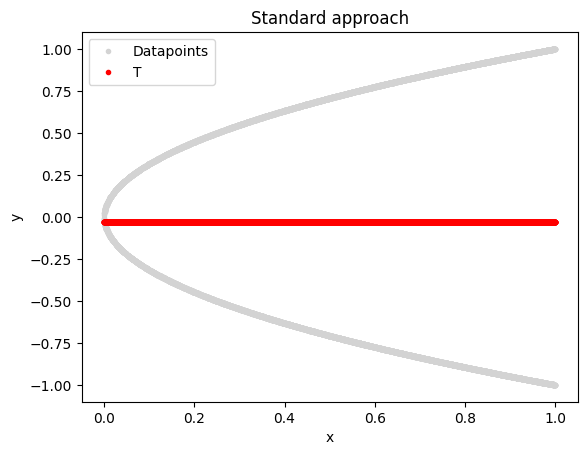

In [13]:
import matplotlib.pyplot as plt 

plt.plot(X,Y,'.',label='Datapoints', color="lightgray")
plt.plot(X, nn_sup(torch.tensor(X)).detach(),'.',label='T',color="red")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Standard approach')
plt.legend()
plt.show()

😱 This is obviously completely wrong! The red solution is nowhere near one of the two modes of our solution shown in gray. The training process has averaged between the data points on both sides of the x-axis and therefore fails to find satisfying solutions to the problem above.

Note that the red line is often not perfectly at zero, which is where the two modes of the solution should average out in the continuous setting. This is caused by the relatively coarse sampling with only 200 points in this example.

## A differentiable physics approach
